### 一、环境准备

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("bright")
np.random.seed(42)

### 二、数据集导入与字段理解

In [138]:
## 用pandas读入数据，得到训练和测试的dataframe
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

In [139]:
## 给test_df加一列Survived量，先全部设置为NaN
test_df.insert(1, 'Survived', None)

## 合并两个数据集
all_data = pd.concat([train_df, test_df], ignore_index=True)

In [140]:
## 查看数据的字段及其值
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 三、缺失值处理

##### 1. 概览数据情况

In [141]:
## 数据概况
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


可以看到，在全部数据中:
- "Fare"字段缺失了1个值
- "Embarked"字段缺失了2个值
- "Age"字段缺失了263个值
- "Cabin"字段缺失了1014个值

##### 2. 处理缺失值

- Fare

In [142]:
## 均值填充
fare_mean = all_data['Fare'].mean()
all_data['Fare'].fillna(fare_mean, inplace=True)

- Embarked

In [143]:
## 众数填充
embarked_mode = all_data['Embarked'].mode()[0]
all_data['Embarked'].fillna(embarked_mode, inplace=True)

- Age

<AxesSubplot:xlabel='Age', ylabel='Density'>

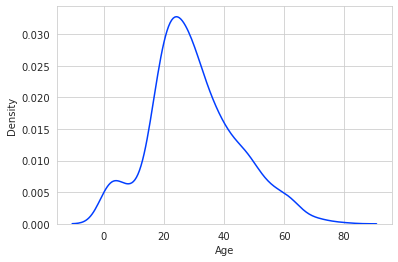

In [144]:
## 绘制出存在的Age数据的分布
sns.kdeplot(all_data['Age'])

In [145]:
## 使用未缺失年龄的均值一个标准差内的随机数填充
age_mean = all_data['Age'].mean()
all_data['Age'].fillna(np.random.normal(age_mean, 1), inplace=True)

- Cabin

In [146]:
## 将有无Cabin作为一个新特征Has_Cabin，有则填充1，无则填充0
all_data['Has_Cabin'] = 1 - all_data['Cabin'].isna()

### 四、异常值处理

In [147]:
## 查看数据统计情况
all_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.980936,0.498854,0.385027,33.295479,0.225363
std,378.020061,0.837836,12.884732,1.041658,0.865560,51.738879,0.417981
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,3.000000,30.377852,0.000000,0.000000,14.454200,0.000000
75%,982.000000,3.000000,35.000000,1.000000,0.000000,31.275000,0.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


<AxesSubplot:ylabel='Age'>

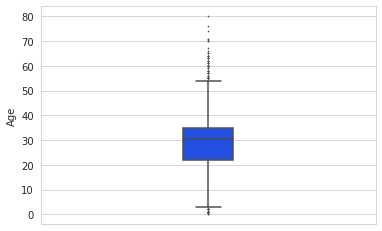

In [148]:
## 给Age字段画出箱形图
sns.boxplot(y = all_data['Age'], width=0.15, fliersize=0.8)

### 五、数据变换

- Ticket

In [149]:
## 删除PassengerId
all_data.drop(columns=['Ticket'], inplace=True)

- Sex

In [150]:
## Male -> 0, Female -> 1
sex_map = pd.factorize(all_data['Sex'])
all_data['Sex'] = sex_map[0]

- Embarked

In [151]:
## S -> 0, C -> 1, Q -> 2
embarked_map = pd.factorize(all_data['Embarked'])
all_data['Embarked'] = embarked_map[0]

- Name

In [152]:
## 添加一行Title列，初始全置为0
all_data.insert(4, 'Title', 0)
## 获取含有关键词的列
mr_class = all_data['Name'].str.contains('Mr\.')
miss_class = all_data['Name'].str.contains('Miss\.')
mrs_class = all_data['Name'].str.contains('Mrs\.')
master_class = all_data['Name'].str.contains('Master\.')
## Mr. -> 1, Mrs./Miss -> 2, Master. -> 3
all_data.loc[all_data['Name'].str.contains('Mr\.'), 'Title'] = 1
all_data.loc[(all_data['Name'].str.contains('Miss\.')) | (all_data['Name'].str.contains('Mrs\.')), 'Title'] = 2
all_data.loc[all_data['Name'].str.contains('Master\.'), 'Title'] = 3

### 六、特征工程